##Algorithm

In [1]:
!pip install datasets

In [2]:
#put the value of your secret as generated by your Hugging Face
from huggingface_hub import notebook_login

notebook_login()

In [2]:
# mount to drive and read dataset
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoTokenizer, RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, DistilBertConfig, EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
import datasets
from datasets import Dataset, DatasetDict
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
# change the path according to your preferences
path ='/content/drive/MyDrive/Masters_Thesis/'
path_GAT = '/content/drive/MyDrive/Masters_Thesis/HierGAT'

df = pd.read_csv(path + "companies.csv")
df_map=pd.read_csv(path + "Companies_map.csv")
df_full = pd.read_csv(path + "Companies_map_joined.csv")
print(df.head())
print(df.shape)

<ipython-input-4-2311810ffb1c>:5: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "companies.csv")
<ipython-input-4-2311810ffb1c>:7: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(path + "Companies_map_joined.csv")


                                     id                          name  \
0  6cd55bda-ad85-dd03-c385-572c12f7bc34                iCelebrate.com   
1  104bd03f-91c9-4666-b74a-d7fda795c8cd                       BioHemp   
2  a2c7210c-dc60-4a0b-a580-14db2dc9142f                  12Tone Music   
3  d6cf2e25-a742-0002-7ba2-5f735c974734      Market Quality Dashboard   
4  6aa10db6-dca6-4d78-b8ef-0feed3dd9413  Innovative Software Services   

  legal_name alias1 alias2 alias3 phone  \
0        NaN    NaN    NaN    NaN   NaN   
1        NaN    NaN    NaN    NaN   NaN   
2        NaN    NaN    NaN    NaN   NaN   
3        NaN    NaN    NaN    NaN   NaN   
4        NaN    NaN    NaN    NaN   NaN   

                                      crunchbase_url  \
0  https://www.crunchbase.com/organization/iceleb...   
1    https://www.crunchbase.com/organization/biohemp   
2  https://www.crunchbase.com/organization/12tone...   
3  https://www.crunchbase.com/organization/market...   
4  https://www.crunchb

In [5]:
df_full.columns

Index(['map_id', 'id', 'name', 'id_1', 'name_1', 'legal_name', 'alias1',
       'alias2', 'alias3', 'phone', 'crunchbase_url', 'homepage_url',
       'linkedin_url', 'twitter_url', 'facebook_url', 'instagram_handle',
       'completeness_score', 'updated_at', 'SOURCE'],
      dtype='object')

In [6]:
df_full = df_full.drop(columns = ["id_1", "name_1"])
df_full = df_full.drop_duplicates(subset='id', keep='first')

In [7]:
df_full['label_source'] = label_encoder.fit_transform(df_full['SOURCE'])
print(df_full.head(2))

           map_id                                    id            name  \
0  1a0eb5fb550054  6cd55bda-ad85-dd03-c385-572c12f7bc34  iCelebrate.com   
1  22ba1a76b3a9d6  104bd03f-91c9-4666-b74a-d7fda795c8cd         BioHemp   

  legal_name alias1 alias2 alias3 phone  \
0        NaN    NaN    NaN    NaN   NaN   
1        NaN    NaN    NaN    NaN   NaN   

                                      crunchbase_url  \
0  https://www.crunchbase.com/organization/iceleb...   
1    https://www.crunchbase.com/organization/biohemp   

                       homepage_url linkedin_url twitter_url facebook_url  \
0         http://www.iCelebrate.com          NaN         NaN          NaN   
1  https://www.biohempnaturals.com/          NaN         NaN          NaN   

  instagram_handle  completeness_score               updated_at   SOURCE  \
0              NaN                 0.5  2018-02-13 00:49:38 UTC  source1   
1              NaN                 0.5  2022-04-11 10:25:35 UTC  source1   

   label_sourc

<ipython-input-7-5476fe9cc65b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['label_source'] = label_encoder.fit_transform(df_full['SOURCE'])


In [8]:
# Step 1: Group the DataFrame by 'map_id'
label_encoder = LabelEncoder()

# Fit-label transform the 'id' column
df_full['map_id_encoded'] = label_encoder.fit_transform(df_full['map_id'])

In [9]:
value_counts = df_full['name'].value_counts()
duplicates_count = value_counts[value_counts > 1]
print("\nCount of duplicate values in 'name' column:")
print(duplicates_count)


Count of duplicate values in 'name' column:
name
Tachyon             5
ICONIC              4
Synergy             4
Flare               4
Vault               4
                   ..
Med-Enterprise      2
Cornell Surgical    2
Ardmore Shipping    2
AGRI WORKS          2
Retail Rocket       2
Name: count, Length: 3007, dtype: int64


In [10]:
value_counts = df_full['alias1'].value_counts()
duplicates_count = value_counts[value_counts > 1]
print("\nCount of duplicate values in 'name' column:")
print(duplicates_count)


Count of duplicate values in 'name' column:
alias1
CPS    6
ACE    6
SP     5
MCA    4
ASC    4
      ..
JSW    2
ACC    2
ASV    2
PSG    2
MW     2
Name: count, Length: 167, dtype: int64


In [11]:
# Filter the DataFrame based on the column value
filtered_df = df_full[df_full["name"] == "Tachyon"]

# Print the filtered rows
filtered_df

,map_id,id,name,legal_name,alias1,alias2,alias3,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,completeness_score,updated_at,SOURCE,label_source,map_id_encoded
10003,1fda52cc112d4c,6865cb3e-11aa-4de1-a1f0-adc0711819eb,Tachyon,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/tachyo...,https://tachyonhub.com/,https://www.linkedin.com/company/tachyonhub/,https://twitter.com/TachyonHub,NaN,NaN,0.666667,2022-12-28 08:30:45 UTC,source1,0,74947
32009,1fda52cc112d4c,HDIklj8N68Tu83sId1D_36MKrDGXN-IIKAIXtWSb2Q8,Tachyon,NaN,NaN,NaN,NaN,NaN,NaN,https://tachyonhub.com,http://linkedin.com/company/tachyonhub,https://twitter.com/tachyonhub,NaN,NaN,0.727273,2022-12-15 00:00:00 UTC,source3,2,74947
40047,22824d5d071b0f,5e8001c7-3765-457f-8bc9-333ef19181e0,Tachyon,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/tachyon-2,NaN,https://www.linkedin.com/company/tachyon-mobil...,https://twitter.com/tachyonmobility,NaN,NaN,0.600000,2023-04-13 07:46:12.855409 UTC,source2,1,81161
44903,00347a9a5c0fef,b4401b14-5655-475e-aa89-3a3602068140,Tachyon,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/tachyon,http://tachyon-project.org,https://www.linkedin.com/company/alluxio-inc-,https://twitter.com/alluxio,NaN,NaN,0.800000,2023-04-13 07:46:12.855409 UTC,source2,1,505
98602,1ab6ddef10ff02,f9b8fede-d8ce-4984-ae20-de139e2ce3c2,Tachyon,Tachyon Inc.,タキオン,NaN,NaN,03-5833-6823,https://www.crunchbase.com/organization/tachyo...,https://www.tachyonworks.co.jp/,NaN,NaN,NaN,NaN,0.750000,2020-10-27 05:00:37 UTC,source1,0,62922


In [12]:
df_full.to_csv('companies_map_full.csv')

In [13]:
# !pip install JPype1
# !pip install aspose-cells

In [14]:
# import  jpype
# import  asposecells
# jpype.startJVM()
# from asposecells.api import Workbook
# workbook = Workbook("companies_map_full.csv")
# workbook.save("companies_map_full.txt")
# jpype.shutdownJVM()


In [13]:
df1 = df["SOURCE"] == "source1"
df1

0        True
1        True
2        True
3        True
4        True
         ... 
99995    True
99996    True
99997    True
99998    True
99999    True
Name: SOURCE, Length: 100000, dtype: bool

In [14]:
k = 0
for i in df1:
  if i == True:
    k+=1
print(k)

47190


###Custom Blocker

In [18]:
from collections import defaultdict

def standard_blocking(field_values: pd.Series) -> dict[str, list]:

    blocks = defaultdict(list)
    for idx, key in enumerate(field_values):
      if idx in [0,1,2,3]:
        print(idx,key, )
        if key is not None:
          blocks[key].append(idx)

    return blocks

In [19]:
sb_name = standard_blocking(df_full.name)
sb_name

0 iCelebrate.com
1 BioHemp
2 12Tone Music
3 Market Quality Dashboard


defaultdict(list,
            {'iCelebrate.com': [0],
             'BioHemp': [1],
             '12Tone Music': [2],
             'Market Quality Dashboard': [3]})

###Splink

In [15]:
!pip install splink

In [16]:
# Initialise the linker, passing in the input dataset(s)
from splink.duckdb.linker import DuckDBLinker
import splink.duckdb.comparison_library as cl
import splink.duckdb.comparison_template_library as ctl
from splink.duckdb.blocking_rule_library import block_on
from splink.datasets import splink_datasets

linker = DuckDBLinker(df)

In [17]:
linker.missingness_chart()

alt.LayerChart(...)

In [18]:
df["unique_id"] = df["id"]
df_full["unique_id"] = df_full["id"]

In [19]:
df_full.head(2)

,map_id,id,name,legal_name,alias1,alias2,alias3,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,completeness_score,updated_at,SOURCE,label_source,map_id_encoded,unique_id
0,1a0eb5fb550054,6cd55bda-ad85-dd03-c385-572c12f7bc34,iCelebrate.com,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/iceleb...,http://www.iCelebrate.com,NaN,NaN,NaN,NaN,0.5,2018-02-13 00:49:38 UTC,source1,0,61388,6cd55bda-ad85-dd03-c385-572c12f7bc34
1,22ba1a76b3a9d6,104bd03f-91c9-4666-b74a-d7fda795c8cd,BioHemp,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/biohemp,https://www.biohempnaturals.com/,NaN,NaN,NaN,NaN,0.5,2022-04-11 10:25:35 UTC,source1,0,81703,104bd03f-91c9-4666-b74a-d7fda795c8cd


In [20]:
df1 = df[df["SOURCE"]=="source1"]
print(df1.shape)
print(df1.head(2))

(47190, 17)
                                     id            name legal_name alias1  \
0  6cd55bda-ad85-dd03-c385-572c12f7bc34  iCelebrate.com        NaN    NaN   
1  104bd03f-91c9-4666-b74a-d7fda795c8cd         BioHemp        NaN    NaN   

  alias2 alias3 phone                                     crunchbase_url  \
0    NaN    NaN   NaN  https://www.crunchbase.com/organization/iceleb...   
1    NaN    NaN   NaN    https://www.crunchbase.com/organization/biohemp   

                       homepage_url linkedin_url twitter_url facebook_url  \
0         http://www.iCelebrate.com          NaN         NaN          NaN   
1  https://www.biohempnaturals.com/          NaN         NaN          NaN   

  instagram_handle  completeness_score               updated_at   SOURCE  \
0              NaN                 0.5  2018-02-13 00:49:38 UTC  source1   
1              NaN                 0.5  2022-04-11 10:25:35 UTC  source1   

                              unique_id  
0  6cd55bda-ad85-dd03-c3

In [21]:
linker = DuckDBLinker(df1)
linker.missingness_chart()

alt.LayerChart(...)

In [22]:
df2 = df[df["SOURCE"]=="source2"]
df3 = df[df["SOURCE"]=="source3"]

In [23]:
print(df2.head(2))
print(df3.head(2))

                                       id            name legal_name alias1  \
386  5a0bf041-324f-44dd-9a9b-7f9d0f521101           Jitsi        NaN    NaN   
685  d4e85ad3-7132-4f06-92c2-f1eef3d29f0c  Arclight Media        NaN    NaN   

    alias2 alias3 phone                                     crunchbase_url  \
386    NaN    NaN   NaN                                                NaN   
685    NaN    NaN   NaN  https://www.crunchbase.com/organization/arclig...   

                 homepage_url linkedin_url                    twitter_url  \
386                       NaN          NaN  https://twitter.com/jitsinews   
685  http://arclightmedia.com          NaN                            NaN   

    facebook_url instagram_handle  completeness_score  \
386          NaN              NaN                 0.5   
685          NaN              NaN                 0.5   

                        updated_at   SOURCE  \
386  2023-05-08 11:42:23.93134 UTC  source2   
685  2023-05-08 11:42:23.9313

In [24]:
linker = DuckDBLinker(df2)
linker.missingness_chart()

alt.LayerChart(...)

In [25]:
linker = DuckDBLinker(df3)
linker.missingness_chart()

alt.LayerChart(...)

In [26]:
from splink.duckdb.linker import DuckDBLinker
from splink.duckdb.blocking_rule_library import block_on
settings = {"link_type": "dedupe_only"}
linker = DuckDBLinker(df1, settings)

blocking_rule_1 = block_on("name")
count = linker.count_num_comparisons_from_blocking_rule(blocking_rule_1)
print(f"Number of comparisons generated by '{blocking_rule_1.blocking_rule_sql}': {count:,.0f}")

Number of comparisons generated by 'l."name" = r."name"': 101


In [92]:
# {
#                 "output_column_name": "soundex",
#                 "comparison_levels": [
#                     null_level("soundex"),
#                     exact_match_level("soundex"),
#                     else_level(),
#                 ],
#             },
#             {
#                 "output_column_name": "email",
#                 "comparison_levels": [
#                     null_level("email"),
#                     exact_match_level("email", term_frequency_adjustments=True),
#                     else_level(),
#                 ],
#             },
#             {
#                 "output_column_name": "city",
#                 "comparison_levels": [
#                     null_level("city"),
#                     exact_match_level("city", term_frequency_adjustments=True),
#                     else_level(),
#                 ],
#             },
#             {
#                 "output_column_name": "country",
#                 "comparison_levels": [
#                     null_level("country"),
#                     exact_match_level("country", term_frequency_adjustments=True),
#                     else_level(),
#                 ],
#             },
#             {
#                 "output_column_name": "stage",
#                 "comparison_levels": [
#                     null_level("stage"),
#                     exact_match_level("stage", term_frequency_adjustments=True),
#                     else_level(),
#                 ],
#             },
#             {
#                 "output_column_name": "employee_count",
#                 "comparison_levels": [
#                     null_level("employee_count"),
#                     exact_match_level(
#                         "employee_count", term_frequency_adjustments=True
#                     ),
#                     else_level(),
#                 ],
#             },
#             {
#                 "output_column_name": "foundation_year",
#                 "comparison_levels": [
#                     null_level("foundation_year"),
#                     exact_match_level(
#                         "foundation_year", term_frequency_adjustments=True
#                     ),
#                     else_level(),
#                 ],
#       },

In [93]:
# "blocking_rules_to_generate_predictions": [
#             "l.homepage_url = r.homepage_url AND SUBSTR(l.soundex, 1, LENGTH(l.soundex) - 1) = SUBSTR(r.soundex, 1, LENGTH(r.soundex) - 1) ",
#             "SUBSTR(l.soundex, 1, LENGTH(l.soundex) - 1)  = SUBSTR(r.soundex, 1, LENGTH(r.soundex) - 1) \
#             AND ((l.crunchbase_url = r.crunchbase_url) OR (l.homepage_url = r.homepage_url) OR (l.linkedin_url = r.linkedin_url) \
#             OR (l.twitter_url = r.twitter_url) OR (l.facebook_url = r.facebook_url))",
#             "l.crunchbase_url = r.crunchbase_url",
#             "l.SOURCE = NOT r.SOURCE"

In [27]:
df_full.head(2)

,map_id,id,name,legal_name,alias1,alias2,alias3,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,completeness_score,updated_at,SOURCE,label_source,map_id_encoded,unique_id
0,1a0eb5fb550054,6cd55bda-ad85-dd03-c385-572c12f7bc34,iCelebrate.com,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/iceleb...,http://www.iCelebrate.com,NaN,NaN,NaN,NaN,0.5,2018-02-13 00:49:38 UTC,source1,0,61388,6cd55bda-ad85-dd03-c385-572c12f7bc34
1,22ba1a76b3a9d6,104bd03f-91c9-4666-b74a-d7fda795c8cd,BioHemp,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/biohemp,https://www.biohempnaturals.com/,NaN,NaN,NaN,NaN,0.5,2022-04-11 10:25:35 UTC,source1,0,81703,104bd03f-91c9-4666-b74a-d7fda795c8cd


In [28]:
from splink.duckdb.linker import DuckDBLinker
from splink.duckdb.blocking_rule_library import block_on
import splink.duckdb.comparison_library as cl
import splink.duckdb.comparison_template_library as ctl
from splink.duckdb.comparison_level_library import null_level, exact_match_level, levenshtein_level, else_level

settings = {
    "link_type": "dedupe_only",
    "comparisons": [
         {
                "output_column_name": "name",
                "comparison_levels": [
                    null_level("name"),
                    exact_match_level("name"),
                    levenshtein_level("name", 2),
                    else_level(),
                ],
            },
            {
                "output_column_name": "phone",
                "comparison_levels": [
                    null_level("phone"),
                    exact_match_level("phone", term_frequency_adjustments=True),
                    else_level(),
                ],
            },
            {
                "output_column_name": "homepage_url",
                "comparison_levels": [
                    null_level("homepage_url"),
                    exact_match_level("homepage_url", term_frequency_adjustments=True),
                    else_level(),
                ],
            },
            {
                "output_column_name": "crunchbase_url",
                "comparison_levels": [
                    null_level("crunchbase_url"),
                    exact_match_level("crunchbase_url"),
                    else_level(),
                ],
            },
            {
                "output_column_name": "facebook_url",
                "comparison_levels": [
                    null_level("facebook_url"),
                    exact_match_level("facebook_url", term_frequency_adjustments=True),
                    else_level(),
                ],
            },
            {
                "output_column_name": "linkedin_url",
                "comparison_levels": [
                    null_level("linkedin_url"),
                    exact_match_level("linkedin_url", term_frequency_adjustments=True),
                    else_level(),
                ],
            },
            {
                "output_column_name": "twitter_url",
                "comparison_levels": [
                    null_level("twitter_url"),
                    exact_match_level("twitter_url", term_frequency_adjustments=True),
                    else_level(),
                ],
            },
    ],
    "blocking_rules_to_generate_predictions": [
            "l.homepage_url = r.homepage_url AND (l.label_source = NOT r.label_source)",
            " (l.label_source = NOT r.label_source) AND ((l.crunchbase_url = r.crunchbase_url) OR (l.homepage_url = r.homepage_url) OR (l.linkedin_url = r.linkedin_url) \
            OR (l.twitter_url = r.twitter_url) OR (l.facebook_url = r.facebook_url))",
            "l.crunchbase_url = r.crunchbase_url",
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
}

linker = DuckDBLinker(df_full, settings)

In [29]:
linker.completeness_chart()

alt.LayerChart(...)

In [30]:
linker.load_settings(settings)

In [31]:
#linker.profile_columns()
df_q = linker.deterministic_link()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [32]:
linker.estimate_u_using_random_sampling(max_pairs=1e6)

INFO:splink.estimate_u:----- Estimating u probabilities using random sampling -----
INFO:splink.m_u_records_to_parameters:u probability not trained for phone - Exact match (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
INFO:splink.m_u_records_to_parameters:u probability not trained for homepage_url - Exact match (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
INFO:splink.m_u_records_to_parameters:u probability not trained for facebook_url - Exact match (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
INFO:splink.estimate_u:
Estimated u probabilities using random sampling
INFO:splink.settings:
Your model is not yet fully trained. Missing estimates for:
    - name (no m values are trained).
    - phone (some u values are not trained, no m values are trained).
    - homepage_url (some u values are not t

In [33]:
linker.estimate_m_from_label_column("crunchbase_url")

INFO:splink.m_training:---- Estimating m probabilities using from column crunchbase_url -----
INFO:splink.m_u_records_to_parameters:m probability not trained for phone - Exact match (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
INFO:splink.m_u_records_to_parameters:m probability not trained for phone - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.
INFO:splink.m_u_records_to_parameters:m probability not trained for crunchbase_url - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.
INFO:splink.settings:
Your model is not yet fully trained. Missing estimates for:
    - phone (some u values are not trained, no m values are trained).
    - homepage_url (some u values are not trained).
    - crunchbase_url (some m values are not trained).
    - facebook_url (so

In [34]:
df_predictions = linker.predict(threshold_match_probability=0.2)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

 -- WARNING --
You have called predict(), but there are some parameter estimates which have neither been estimated or specified in your settings dictionary.  To produce predictions the following untrained trained parameters will use default values.
Comparison: 'phone':
    m values not fully trained
Comparison: 'phone':
    u values not fully trained
Comparison: 'homepage_url':
    u values not fully trained
Comparison: 'crunchbase_url':
    m values not fully trained
Comparison: 'facebook_url':
    u values not fully trained
The 'probability_two_random_records_match' setting has been set to the default value (0.0001). 
If this is not the desired behaviour, either: 
 - assign a value for `probability_two_random_records_match` in your settings dictionary, or 
 - estimate with the `linker.estimate_probability_two_random_records_match` function.


In [35]:
linker.match_weights_chart()

alt.VConcatChart(...)

In [40]:
df_linker_pred = df_predictions.as_pandas_dataframe()
# Show the predictions
print(df_linker_pred)

# Save predictions to a CSV file
#df_predictions.to_csv("predictions.csv")

      match_weight  match_probability                           unique_id_l  \
0        -1.572765           0.251589  79550af0-f70e-4eb1-8125-5573471492f0   
1        -1.572765           0.251589  8d016e47-620b-48c3-b318-d5e88531f06a   
2        -1.572765           0.251589  2ff67347-8018-41d9-b0bf-d45a298f4bea   
3        -1.572765           0.251589  d6d9fd1c-6aaf-d60b-981d-813ef0eee6c3   
4        -1.138534           0.312347  11ea8e29-055e-3855-b289-138ce9e70a2e   
...            ...                ...                                   ...   
1367     63.582715           1.000000  50508e0d-838c-2799-ab34-34dde8f5d258   
1368     63.582715           1.000000  1135fdd6-2387-baa6-f3b4-28ec415df0d7   
1369     63.665633           1.000000  57417123-0e1b-4a25-87e3-f0cd1b10a2a0   
1370     63.665633           1.000000  69d36a60-dcdf-462d-8bd6-053e209bb559   
1371     64.080387           1.000000  02c32053-5548-d3f3-b6d4-ccdaa1ecb054   

                               unique_id_r         

In [36]:
records_to_view  = df_predictions.as_record_dict(limit=5)
linker.waterfall_chart(records_to_view, filter_nulls=False)

alt.LayerChart(...)

In [37]:
result = df[df['id'] == 'u0tZwHEGNgGm_DhrATtXjpQk9qGfxJymiQA5X5xwPZ4']
result

,id,name,legal_name,alias1,alias2,alias3,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,completeness_score,updated_at,SOURCE,unique_id
22190,u0tZwHEGNgGm_DhrATtXjpQk9qGfxJymiQA5X5xwPZ4,Total Uptime,NaN,NaN,NaN,NaN,18005841514,NaN,https://totaluptime.com,https://linkedin.com/company/totaluptime/about,https://twitter.com/totaluptime,http://facebook.com/totaluptime,NaN,0.909091,2022-12-18 00:00:00 UTC,source3,u0tZwHEGNgGm_DhrATtXjpQk9qGfxJymiQA5X5xwPZ4


In [41]:
df_full[df_full['unique_id'] == df_linker_pred.iloc[1]['unique_id_l']]

,map_id,id,name,legal_name,alias1,alias2,alias3,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,completeness_score,updated_at,SOURCE,label_source,map_id_encoded,unique_id
46363,1bc16400fc183b,8d016e47-620b-48c3-b318-d5e88531f06a,Hailstorm Commerce,NaN,NaN,NaN,NaN,NaN,https://www.crunchbase.com/organization/hailstorm,http://hailstorm.ie,https://www.linkedin.com/company/hailstorm-com...,https://twitter.com/hscommerce,https://www.facebook.com/hailstormcommerce,NaN,0.9,2023-04-13 07:46:12.855409 UTC,source2,1,65475,8d016e47-620b-48c3-b318-d5e88531f06a


In [42]:
df_label = df_linker_pred.copy()
df_label['unique_id_l'] = 0
df_label['unique_id_r'] = 0
df_label['source_dataset_l'] = 0
df_label['source_dataset_r'] = 0
df_label['clerical_match_score'] = 0
columns_to_keep = ['unique_id_l', 'unique_id_r','source_dataset_l','source_dataset_r','clerical_match_score']
#df_reduced = df.loc[:, columns_to_keep]

df_reduced = df_label.filter(columns_to_keep)
df_reduced.head()

,unique_id_l,unique_id_r,source_dataset_l,source_dataset_r,clerical_match_score
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [43]:
df_label = df_reduced.copy()

# Label the data using map_id
for i in df_linker_pred.index:
  df_label.at[i, 'unique_id_l'] = df_linker_pred.iloc[i]['unique_id_l']
  df_label.at[i, 'unique_id_r']= df_linker_pred.iloc[i]['unique_id_r']
  df_label.at[i, 'source_dataset_l'] = "df_full"
  df_label.at[i, 'source_dataset_r'] = "df_full"
  row_l = df_full[df_full['unique_id'] == df_linker_pred.iloc[i]['unique_id_l']]
  val_l = int(row_l["map_id_encoded"].describe()['min'])
  row_r = df_full[df_full['unique_id'] == df_linker_pred.iloc[i]['unique_id_r']]
  val_r = int(row_r["map_id_encoded"].describe()['min'])
  if val_l == val_r:
    df_label.at[i, 'clerical_match_score'] = 1
  else:
    df_label.at[i, 'clerical_match_score'] = 0
df_label.head()

,unique_id_l,unique_id_r,source_dataset_l,source_dataset_r,clerical_match_score
0,79550af0-f70e-4eb1-8125-5573471492f0,cd22e79f-2b0b-0933-73ac-eb5ba206af8b,df_full,df_full,1
1,8d016e47-620b-48c3-b318-d5e88531f06a,94f572d8-16fa-bb8e-3295-6405bd6d7718,df_full,df_full,1
2,2ff67347-8018-41d9-b0bf-d45a298f4bea,673b93bf-7060-442f-a087-bedfe5ecd9fb,df_full,df_full,1
3,d6d9fd1c-6aaf-d60b-981d-813ef0eee6c3,ff7d76ba-3710-479f-8832-2acf65a63916,df_full,df_full,1
4,11ea8e29-055e-3855-b289-138ce9e70a2e,2e2bedd0-5da6-44bc-8238-4f59c7a1df64,df_full,df_full,1


In [44]:
labels_table = linker.register_labels_table(df_label)
linker.roc_chart_from_labels_table(labels_table)

alt.Chart(...)

In [45]:
roc_table = linker.truth_space_table_from_labels_table(labels_table)
roc_df = roc_table.as_pandas_dataframe()
roc_df.head()

,truth_threshold,match_probability,row_count,p,n,tp,tn,fp,fn,P_rate,...,precision,recall,specificity,npv,accuracy,f1,f2,f0_5,p4,phi
0,-1.572765,0.251589,1372.0,1364.0,8.0,1364.0,0.0,8.0,0.0,0.994169,...,0.994169,1.000000,0.000,1.000000,0.994169,0.997076,0.998828,0.995330,0.000000,0.000000
1,-1.138534,0.312347,1372.0,1364.0,8.0,1360.0,0.0,8.0,4.0,0.994169,...,0.994152,0.997067,0.000,0.000000,0.991254,0.995608,0.996483,0.994734,0.000000,-0.004141
2,-0.915165,0.346526,1372.0,1364.0,8.0,1358.0,1.0,7.0,6.0,0.994169,...,0.994872,0.995601,0.125,0.142857,0.990525,0.995236,0.995455,0.995018,0.235162,0.128881
3,-0.742336,0.374128,1372.0,1364.0,8.0,1357.0,1.0,7.0,7.0,0.994169,...,0.994868,0.994868,0.125,0.125000,0.989796,0.994868,0.994868,0.994868,0.222095,0.119868
4,-0.308104,0.446812,1372.0,1364.0,8.0,1354.0,1.0,7.0,10.0,0.994169,...,0.994857,0.992669,0.125,0.090909,0.987609,0.993761,0.993105,0.994418,0.190362,0.100459


In [46]:
roc_df

,truth_threshold,match_probability,row_count,p,n,tp,tn,fp,fn,P_rate,...,precision,recall,specificity,npv,accuracy,f1,f2,f0_5,p4,phi
0,-1.572765,0.251589,1372.0,1364.0,8.0,1364.0,0.0,8.0,0.0,0.994169,...,0.994169,1.000000,0.000,1.000000,0.994169,0.997076,0.998828,0.995330,0.000000,0.000000
1,-1.138534,0.312347,1372.0,1364.0,8.0,1360.0,0.0,8.0,4.0,0.994169,...,0.994152,0.997067,0.000,0.000000,0.991254,0.995608,0.996483,0.994734,0.000000,-0.004141
2,-0.915165,0.346526,1372.0,1364.0,8.0,1358.0,1.0,7.0,6.0,0.994169,...,0.994872,0.995601,0.125,0.142857,0.990525,0.995236,0.995455,0.995018,0.235162,0.128881
3,-0.742336,0.374128,1372.0,1364.0,8.0,1357.0,1.0,7.0,7.0,0.994169,...,0.994868,0.994868,0.125,0.125000,0.989796,0.994868,0.994868,0.994868,0.222095,0.119868
4,-0.308104,0.446812,1372.0,1364.0,8.0,1354.0,1.0,7.0,10.0,0.994169,...,0.994857,0.992669,0.125,0.090909,0.987609,0.993761,0.993105,0.994418,0.190362,0.100459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,63.422787,1.000000,1372.0,1364.0,8.0,17.0,8.0,0.0,1347.0,0.994169,...,1.000000,0.012463,1.000,0.005904,0.018222,0.024620,0.015531,0.059358,0.015898,0.008578
273,63.443892,1.000000,1372.0,1364.0,8.0,15.0,8.0,0.0,1349.0,0.994169,...,1.000000,0.010997,1.000,0.005895,0.016764,0.021755,0.013709,0.052669,0.015235,0.008052
274,63.582715,1.000000,1372.0,1364.0,8.0,11.0,8.0,0.0,1353.0,0.994169,...,1.000000,0.008065,1.000,0.005878,0.013848,0.016000,0.010060,0.039062,0.013508,0.006885
275,63.665633,1.000000,1372.0,1364.0,8.0,3.0,8.0,0.0,1361.0,0.994169,...,1.000000,0.002199,1.000,0.005844,0.008017,0.004389,0.002748,0.010901,0.006372,0.003585


In [47]:
roc_df['precision'].mean()


0.997863269581423

In [49]:
roc_df['f1'].mean()

0.6547907002214545

In [50]:
roc_df['recall'].mean()

0.5622690748171125

In [ ]:
# df_true = df_label['match']
# df_true

In [51]:
df_q.as_pandas_dataframe(limit=5)


,unique_id_l,unique_id_r,name_l,name_r,phone_l,phone_r,tf_phone_l,tf_phone_r,homepage_url_l,homepage_url_r,...,tf_linkedin_url_l,tf_linkedin_url_r,twitter_url_l,twitter_url_r,tf_twitter_url_l,tf_twitter_url_r,label_source_l,label_source_r,match_key,match_probability
0,0b3afd38-0e9d-4de6-a1df-b59cb33d00a7,9aee14a6-8fff-4d23-b8a7-b55a22994866,Ur Fashion,Ur Fashion,None,None,NaN,NaN,http://www.ur-fashion.nl,http://www.ur-fashion.nl,...,NaN,NaN,None,None,NaN,NaN,1,0,0,1.0
1,3d5176d0-f3b1-476b-91b8-6b8ab5bb9435,d4d2e6fa-1019-a77f-d8e4-a9a4cb269f75,Coco-soft,Cocosoft,None,(510) 338 9819,NaN,0.000022,http://coco-soft.com,http://coco-soft.com,...,0.000017,NaN,https://twitter.com/cocosoftcorp,https://www.twitter.com/cocosoftcorp,0.000022,0.000022,1,0,0,1.0
2,1196ae51-c891-4608-b30d-910dfacfdaae,2b6e2ec7-2ff2-e3d8-66a4-44945a284a2c,Telin,Telin,None,(656) 278-8189,NaN,0.000022,http://telin.sg,http://telin.sg,...,0.000017,NaN,https://twitter.com/infotelin,https://twitter.com/infotelin,0.000045,0.000045,1,0,0,1.0
3,49f9acb3-d738-4e79-a27f-8559e3b8d6b1,6b134abf-3b82-4447-96e7-ac21600dfda1,Edutainmentgames,Edutainmentgames,None,31 (0) 6 182 135 89,NaN,0.000022,http://edutainmentgames.nl,http://edutainmentgames.nl,...,0.000017,0.000017,None,https://twitter.com/ludimogame,NaN,0.000022,1,0,0,1.0
4,3b90d6b3-b526-4e37-bd5a-2a0a815a092a,3caa9d7f-e03f-32ee-99cf-f13ea41b5eae,Bettermeans,Bettermeans,None,4158685119,NaN,0.000022,http://bettermeans.com,http://bettermeans.com,...,NaN,NaN,https://twitter.com/bettermeans,http://twitter.com/bettermeans,0.000022,0.000022,1,0,0,1.0


In [52]:
df_links = df_q.as_pandas_dataframe()
df_links.shape

(1516, 30)

In [53]:
#df_predictions = linker.predict(threshold_match_probability=0.2)
df_predictions.as_pandas_dataframe()

,match_weight,match_probability,unique_id_l,unique_id_r,name_l,name_r,gamma_name,bf_name,phone_l,phone_r,...,twitter_url_l,twitter_url_r,gamma_twitter_url,tf_twitter_url_l,tf_twitter_url_r,bf_twitter_url,bf_tf_adj_twitter_url,label_source_l,label_source_r,match_key
0,-1.572765,0.251589,79550af0-f70e-4eb1-8125-5573471492f0,cd22e79f-2b0b-0933-73ac-eb5ba206af8b,Sportobuddy,Locobuddy Mobile Technology (Sportobuddy),0,0.082639,None,None,...,https://twitter.com/sportobuddy,https://twitter.com/SportoBuddy,0,0.000022,0.000022,0.633932,1.000000,1,0,1
1,-1.572765,0.251589,8d016e47-620b-48c3-b318-d5e88531f06a,94f572d8-16fa-bb8e-3295-6405bd6d7718,Hailstorm Commerce,Hailstorm,0,0.082639,None,+353 61 423 030,...,https://twitter.com/hscommerce,http://twitter.com/hscommerce,0,0.000022,0.000022,0.633932,1.000000,1,0,1
2,-1.572765,0.251589,2ff67347-8018-41d9-b0bf-d45a298f4bea,673b93bf-7060-442f-a087-bedfe5ecd9fb,AcquiBots Technologies Pvt. Ltd.,AcquiBots Technologies Pvt.,0,0.082639,9727279184,None,...,https://twitter.com/acquibots/,https://twitter.com/acquibots,0,0.000022,0.000022,0.633932,1.000000,0,1,1
3,-1.572765,0.251589,d6d9fd1c-6aaf-d60b-981d-813ef0eee6c3,ff7d76ba-3710-479f-8832-2acf65a63916,Adfactors PR,Adfactors PR Pvt.,0,0.082639,02267574444,None,...,https://twitter.com/AdfactorsPR,https://twitter.com/adfactorspr,0,0.000022,0.000022,0.633932,1.000000,0,1,1
4,-1.138534,0.312347,11ea8e29-055e-3855-b289-138ce9e70a2e,2e2bedd0-5da6-44bc-8238-4f59c7a1df64,Aruhat Technologies Pvt. Ltd,Aruhat Technologies Pvt.,0,0.082639,+91-79-40200900,None,...,http://twitter.com/aruhat,https://twitter.com/aruhat,0,0.000022,0.000022,0.633932,1.000000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,63.582715,1.000000,50508e0d-838c-2799-ab34-34dde8f5d258,fbdb8ac6-c6dd-408a-b0a2-fedc3a682302,Hometurph India,Hometurph India,2,409076.292216,134746889111,None,...,https://twitter.com/hometurphindia,https://twitter.com/hometurphindia,1,0.000045,0.000045,71155.500000,0.114474,0,1,1
1368,63.582715,1.000000,1135fdd6-2387-baa6-f3b4-28ec415df0d7,a525ad5f-2f15-42b1-9dd0-94d262f02de2,African Clean Energy,African Clean Energy,2,409076.292216,+31633831208,None,...,https://twitter.com/acelesotho,https://twitter.com/acelesotho,1,0.000045,0.000045,71155.500000,0.114474,0,1,1
1369,63.665633,1.000000,57417123-0e1b-4a25-87e3-f0cd1b10a2a0,83ab8b78-a88a-4c9d-8f1a-8ea0f0a8438f,The Simulation Crew,The Simulation Crew,2,409076.292216,None,31 (0)24 20 22 276,...,https://twitter.com/simulationcrew,https://twitter.com/simulationcrew,1,0.000045,0.000045,71155.500000,0.114474,1,0,0
1370,63.665633,1.000000,69d36a60-dcdf-462d-8bd6-053e209bb559,bd03d896-7b00-495e-b0c4-6bbcc7fdd83c,Agrabid,Agrabid,2,409076.292216,None,(619) 786-0962,...,https://twitter.com/agrabid,https://twitter.com/agrabid,1,0.000045,0.000045,71155.500000,0.114474,1,0,0


##Record Lincage

In [54]:
!pip install recordlinkage

In [55]:
import recordlinkage

In [56]:
#df_full= pd.read_csv("companies_map_full.csv")
df_full = df_full.drop_duplicates(subset='id', keep='first')
columns_to_drop = ['alias1', 'alias2', 'alias3']
df_full.drop(columns=columns_to_drop, axis=1, inplace=True)
print(df_full)

               map_id                                    id  \
0      1a0eb5fb550054  6cd55bda-ad85-dd03-c385-572c12f7bc34   
1      22ba1a76b3a9d6  104bd03f-91c9-4666-b74a-d7fda795c8cd   
2      082f657a6c8016  a2c7210c-dc60-4a0b-a580-14db2dc9142f   
3      1fc600dced0207  d6cf2e25-a742-0002-7ba2-5f735c974734   
4      2d4c05e060d65f  6aa10db6-dca6-4d78-b8ef-0feed3dd9413   
...               ...                                   ...   
99995  2c944a72f24d18  e600d5b4-3fac-4ede-80b3-74752c02d641   
99996  043e7dc3cecc67  51bfe287-0bd0-495b-825a-45fbe2467955   
99997  23271d6ea51877  3746fa07-1b51-8fc3-e643-40b86ab48826   
99998  0901dc7fd8bcc8  73733b23-420c-4aa9-af41-3b5d07966ba9   
99999  1f6f1c80b7ddd3  cfc11db2-4006-4a67-a038-3828cc242dfa   

                               name                      legal_name  \
0                    iCelebrate.com                             NaN   
1                           BioHemp                             NaN   
2                      12Tone 

In [57]:
# Step 1: Group the DataFrame by 'map_id'
label_encoder = LabelEncoder()

# Fit-label transform the 'id' column
df_full['map_id_encoded'] = label_encoder.fit_transform(df_full['map_id'])
grouped = df_full.groupby('map_id')
df_full.drop(columns=["SOURCE", "completeness_score",	"updated_at"], inplace=True)

# Step 2: Identify groups with more than one row
equal_map_id_groups = grouped.filter(lambda x: len(x) > 1)
unique_map_id_groups = grouped.filter(lambda x: len(x) == 1)

# Step 3: Create the new DataFrames
df_f_eq = equal_map_id_groups.sort_values('map_id_encoded')
df_f_neq = unique_map_id_groups

In [58]:
df_f = pd.concat([df_f_eq, df_f_neq])

In [59]:
df_full_train, df_full_test = train_test_split(df_full, test_size=0.2, random_state=42)
df_full_train.drop(columns=["id", "map_id",	"map_id_encoded"], inplace=True)
df_full_test.drop(columns=["id"], inplace=True)

In [60]:
df_f.head()

,map_id,id,name,legal_name,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,label_source,map_id_encoded,unique_id
29787,000426ac5579b5,LKP0HFlNOXjaFJC1dEJvEjJPdJI6MeudRE7uI1spFuk,Yellow Scooter,CROWDERA VENTURES PRIVATE LIMITED,NaN,NaN,https://yellowscooter.studio/,https://linkedin.com/company/yellowscooter/about,https://twitter.com/gocrowdera,https://facebook.com/gocrowdera,NaN,2,39,LKP0HFlNOXjaFJC1dEJvEjJPdJI6MeudRE7uI1spFuk
18520,000426ac5579b5,9737f350-a683-4678-a289-496e68cc22fe,Yellow Scooter Studio,NaN,1 650-242-5246,https://www.crunchbase.com/organization/yellow...,https://yellowscooter.studio/,https://www.linkedin.com/company/yellowscooter,https://twitter.com/YSSProductions,https://www.facebook.com/yellowscooterstudio,NaN,0,39,9737f350-a683-4678-a289-496e68cc22fe
79431,0009268e1f5183,NEGoa5ZnNdfzmmZwRHHPBzgWdlh6wKxiQdh-X1Pk6Zo,Smart House Calls,NaN,NaN,NaN,https://www.smarthousecalls.com/,http://linkedin.com/company/smart-house-calls,http://twitter.com/smarthousecalls,NaN,NaN,2,82,NEGoa5ZnNdfzmmZwRHHPBzgWdlh6wKxiQdh-X1Pk6Zo
11968,0009268e1f5183,fa43a276-6380-462a-88bb-9c89761f93bd,Smart House Calls,"Smart House Calls, LLC",+1 888-665-6967,https://www.crunchbase.com/organization/smart-...,https://www.smarthousecalls.com/,NaN,https://twitter.com/SmartHouseCalls,https://www.facebook.com/SmartHouseCalls,NaN,0,82,fa43a276-6380-462a-88bb-9c89761f93bd
85596,000d0ed6d0bfb3,f724ae02-3d81-4e5f-8474-923f3002036e,Youngstown Foundation,NaN,NaN,https://www.crunchbase.com/organization/youngs...,http://youngstownfoundation.org,https://www.linkedin.com/company/youngstown-fo...,NaN,NaN,NaN,1,125,f724ae02-3d81-4e5f-8474-923f3002036e


In [61]:
df_full_train.head()

,name,legal_name,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,label_source,unique_id
64471,Cellint,NaN,972 8 915 9153,https://www.crunchbase.com/organization/cellint,http://www.cellint.com/,https://www.linkedin.com/company/cellint-traff...,http://twitter.com/Cellint1,NaN,NaN,0,7116a894-09a9-e4f7-c3a6-d0517126e59a
45557,LifeSpan Biosciences,NaN,NaN,https://www.crunchbase.com/organization/lifesp...,NaN,https://www.linkedin.com/company/lsbio/,https://twitter.com/lsbio,https://www.facebook.com/lsbio-152003528149127,NaN,1,222fce0c-1325-4dea-97c9-ff1d1961ac1e
27614,Team Nation Holdings,NaN,NaN,NaN,http://teamnationholdings.com,NaN,NaN,NaN,NaN,2,Hk8gkY3e7r5HOE7A_jbpzEsBN6sWL6FpB3-qOuUoTrI
13568,Pollock Lifts,Pollock Lifts Ltd.,+44 0 28 9336 8167,https://www.crunchbase.com/organization/polloc...,https://www.pollocklifts.co.uk,https://www.linkedin.com/company/pollock-lifts...,https://twitter.com/pollocklifts,https://www.facebook.com/PollockLifts,NaN,0,ca40005c-1337-4e46-bbd2-09c0a9881c4d
92727,Blare Films San Diego,NaN,NaN,https://www.crunchbase.com/organization/san-di...,NaN,https://www.linkedin.com/company/blare-films-s...,https://twitter.com/sdiegovideopro,https://www.facebook.com/videoproductionsandiego,NaN,1,5226feff-15fc-4d5c-b8bf-11f340d5db6c


In [62]:
#df_full.fillna('', inplace=True)
df_full['name'] = df_full['name'].str.lower()
df_full['legal_name'] = df_full['legal_name'].str.lower()
df_1 = df_full[df_full["label_source"]==0]
df_2_3 = df_full[df_full["label_source"]!=0]
print(df_1.shape)
print(df_1.head(2))

(47189, 14)
           map_id                                    id            name  \
0  1a0eb5fb550054  6cd55bda-ad85-dd03-c385-572c12f7bc34  icelebrate.com   
1  22ba1a76b3a9d6  104bd03f-91c9-4666-b74a-d7fda795c8cd         biohemp   

  legal_name phone                                     crunchbase_url  \
0        NaN   NaN  https://www.crunchbase.com/organization/iceleb...   
1        NaN   NaN    https://www.crunchbase.com/organization/biohemp   

                       homepage_url linkedin_url twitter_url facebook_url  \
0         http://www.iCelebrate.com          NaN         NaN          NaN   
1  https://www.biohempnaturals.com/          NaN         NaN          NaN   

  instagram_handle  label_source  map_id_encoded  \
0              NaN             0           61388   
1              NaN             0           81703   

                              unique_id  
0  6cd55bda-ad85-dd03-c385-572c12f7bc34  
1  104bd03f-91c9-4666-b74a-d7fda795c8cd  


In [63]:
df_full_enc = df_full.copy()
# Apply LabelEncoder to each column
for column in df_full_enc.columns:
    df_full_enc[column] = label_encoder.fit_transform(df_full_enc[column])

# Print the transformed DataFrame
df_full_enc.drop(columns = ['map_id_encoded'], inplace=True)
df_full_enc.head(2)

,map_id,id,name,legal_name,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,label_source,unique_id
0,61388,33151,40784,21806,44415,25048,29399,57395,43753,44172,462,0,33151
1,81703,5362,10823,21806,44415,8145,64055,57395,43753,44172,462,0,5362


In [64]:
df_1.head()

,map_id,id,name,legal_name,phone,crunchbase_url,homepage_url,linkedin_url,twitter_url,facebook_url,instagram_handle,label_source,map_id_encoded,unique_id
0,1a0eb5fb550054,6cd55bda-ad85-dd03-c385-572c12f7bc34,icelebrate.com,NaN,NaN,https://www.crunchbase.com/organization/iceleb...,http://www.iCelebrate.com,NaN,NaN,NaN,NaN,0,61388,6cd55bda-ad85-dd03-c385-572c12f7bc34
1,22ba1a76b3a9d6,104bd03f-91c9-4666-b74a-d7fda795c8cd,biohemp,NaN,NaN,https://www.crunchbase.com/organization/biohemp,https://www.biohempnaturals.com/,NaN,NaN,NaN,NaN,0,81703,104bd03f-91c9-4666-b74a-d7fda795c8cd
2,082f657a6c8016,a2c7210c-dc60-4a0b-a580-14db2dc9142f,12tone music,NaN,NaN,https://www.crunchbase.com/organization/12tone...,https://www.12tonemusicgroup.com/,NaN,NaN,NaN,NaN,0,19476,a2c7210c-dc60-4a0b-a580-14db2dc9142f
3,1fc600dced0207,d6cf2e25-a742-0002-7ba2-5f735c974734,market quality dashboard,NaN,NaN,https://www.crunchbase.com/organization/market...,https://www.mqdashboard.com/,NaN,NaN,NaN,NaN,0,74779,d6cf2e25-a742-0002-7ba2-5f735c974734
4,2d4c05e060d65f,6aa10db6-dca6-4d78-b8ef-0feed3dd9413,innovative software services,NaN,NaN,https://www.crunchbase.com/organization/innova...,http://www.issi-central.com/,NaN,NaN,NaN,NaN,0,92196,6aa10db6-dca6-4d78-b8ef-0feed3dd9413


In [65]:
indexer = recordlinkage.Index()
indexer.block(left_on='crunchbase_url', right_on='crunchbase_url')
indexer.block(left_on='homepage_url', right_on='homepage_url')
indexer.block(left_on='name', right_on='name')
candidate_pairs = indexer.index(df_full)

In [66]:
indexer1_0 = recordlinkage.Index()
indexer1_0.random(len(candidate_pairs))
random_pairs = indexer1_0.index(df_full)

In [67]:
comp = recordlinkage.Compare()

# initialise similarity measurement algorithms
comp.string('name', 'name', method='jarowinkler', threshold=0.75)
comp.exact('homepage_url', 'homepage_url')
comp.exact('crunchbase_url', 'crunchbase_url')
comp.string('linkedin_url', 'linkedin_url', method='levenshtein', threshold=0.75)
comp.string('twitter_url', 'twitter_url', method='levenshtein', threshold=0.75)
comp.string('facebook_url', 'facebook_url', method='levenshtein', threshold=0.75)
comp.string('instagram_handle', 'instagram_handle', method='levenshtein', threshold=0.75)
comp.exact('phone', 'phone')

# the method .compute() returns the DataFrame with the feature vectors.
comp_df = comp.compute(candidate_pairs, df_full)

In [68]:
comp_rand_df = comp.compute(random_pairs, df_full)

In [69]:
print(df_full.iloc[57786])
print(df_full.iloc[84668])

map_id                                                 10f85ca0c74084
id                               75ac7b45-eaf1-46f4-8e80-e191b5bf696c
name                                              mis värme & kyla ab
legal_name                                                        NaN
phone                                                   072-246 44 22
crunchbase_url      https://www.crunchbase.com/organization/mis-vä...
homepage_url                              https://www.misvarmekyla.se
linkedin_url                                                      NaN
twitter_url                                                       NaN
facebook_url                    https://www.facebook.com/misvarmekyla
instagram_handle                                                  NaN
label_source                                                        0
map_id_encoded                                                  40216
unique_id                        75ac7b45-eaf1-46f4-8e80-e191b5bf696c
Name: 57787, dtype: 

In [70]:
comp_full_df = pd.concat([comp_df, comp_rand_df])

In [71]:
y_label = comp_full_df.copy()
y_label['match'] = 0
# Label the data using map_id
for i in comp_df.index:
  if df_full.iloc[i[0]]['map_id'] ==  df_full.iloc[i[1]]['map_id']:
    y_label.at[(i[0], i[1]), 'match'] = 1
  else:
    y_label.at[(i[0], i[1]), 'match'] = 0


In [72]:
y_label.head()

,,0,1,2,3,4,5,6,7,match
3402,1415,1.0,0,0,0.0,0.0,0.0,0.0,0,0
5551,3322,0.0,1,0,0.0,0.0,0.0,0.0,1,1
5845,1957,1.0,0,0,0.0,0.0,0.0,0.0,0,0
6364,5977,1.0,0,0,1.0,1.0,0.0,0.0,0,1
6486,6331,1.0,0,0,1.0,1.0,1.0,0.0,0,1


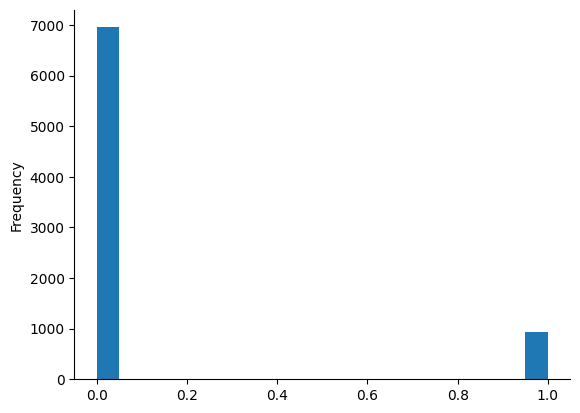

In [73]:
from matplotlib import pyplot as plt
y_label["match"].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_full.fillna(0, inplace=True)
comp_df.fillna(0, inplace=True)

df_output = df_full.copy()
comp_rand_df.fillna(0, inplace=True)
comp_full_df = pd.concat([comp_df, comp_rand_df])

y_label = comp_df.copy()
y_label['match'] = 0
# Label the data using map_id
for i in comp_df.index:
  if df_full.iloc[i[0]]['map_id'] ==  df_full.iloc[i[1]]['map_id']:
    y_label.at[(i[0], i[1]), 'match'] = 1
  else:
    y_label.at[(i[0], i[1]), 'match'] = 0

# Train the Logistic Regression Classifier
y = y_label['match']
X = y_label.drop(columns='match')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_classifier = recordlinkage.LogisticRegressionClassifier()

# Extract indices of matching pairs from y_train
matching_indices_train = y_train[y_train == 1].index

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

lr_classifier.fit(X_train, matching_indices_train)

# Evaluate the classifier
y_pred = lr_classifier.predict(X_test)
#print(classification_report(y_test, y_pred))

# Predict matches on new data
#predictions = lr_classifier.predict(df_full)
#df_output['is_match'] = predictions

In [75]:
y_pred = lr_classifier.predict(comp_df)

In [76]:
print(y_pred)

MultiIndex([(53320, 21798),
            (71640, 11580)],
           )


In [77]:
Correct_pred = pd.DataFrame(index=y_pred, columns=['match'])
Correct_pred['match'] = 0
for i in y_pred:
  if df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']: #TP
    Correct_pred.at[(i[0], i[1]), 'match'] = 1 #TP
  else:
    Correct_pred.at[(i[0], i[1]), 'match'] = 0 #FP
FN = 0
for i in y_test.index:
  if i not in y_pred and df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']:
    FN+=1
pres = sum(Correct_pred['match'])/len(Correct_pred )
recall = sum(Correct_pred['match'])/(sum(Correct_pred['match'])+FN)
F1 = 2*pres*recall/(pres+recall)
print(pres)
print(recall)
print(F1)

0.5
0.0049261083743842365
0.00975609756097561


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_full.fillna('', inplace=True)
comp_df.fillna('', inplace=True)

# Label the data using map_id
matches = df_full[df_full.duplicated('map_id', keep=False)]
matches['pair_id'] = matches.groupby('map_id').cumcount()
matches_pairs = matches.set_index(['map_id', 'pair_id'])

labeled_pairs = comp_df.copy()
labeled_pairs.fillna('', inplace=True)
labeled_pairs['match'] = 0

for map_id, group in matches.groupby('map_id'):
    indices = list(group.index)
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            labeled_pairs.at[(indices[i], indices[j]), 'match'] = 1


print( )
# Train the Logistic Regression Classifier
X = labeled_pairs.drop(columns='match')
y = labeled_pairs['match']

print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_classifier = recordlinkage.LogisticRegressionClassifier()

# Extract indices of matching pairs from y_train
matching_indices_train = y_train[y_train == 1].index

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

lr_classifier.fit(X_train, matching_indices_train)

# Evaluate the classifier
y_pred = lr_classifier.predict(X_test)
#print(classification_report(y_test, y_pred))
print(y_pred)
print(len(y_pred))
# Predict matches on new data
#predictions = lr_classifier.predict(comp_df)
#df['is_match'] = predictions

<ipython-input-78-6eef0095d0be>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['pair_id'] = matches.groupby('map_id').cumcount()



               0    1    2    3    4    5    6    7
3402  1415   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5551  3322   0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0
5845  1957   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6364  5977   1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
6486  6331   1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
...          ...  ...  ...  ...  ...  ...  ...  ...
57786 84668  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
52002 54002  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
23494 94646  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9892  29810  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
13009 41881  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[7792 rows x 8 columns]
3402   1415     0.0
5551   3322     0.0
5845   1957     0.0
6364   5977     0.0
6486   6331     0.0
               ... 
57786  84668    1.0
52002  54002    1.0
23494  94646    1.0
9892   29810    1.0
13009  41881    1.0
Name: match, Length: 7792, dtype: float64
6233
1559
6233
1559
MultiIndex([(17652, 31290),
            (26306, 51694),
            

In [79]:
y_comp = pd.DataFrame(index=y_test.index, columns=['label'])
y_comp['label'] = 0
for i in y_test.index:
  if i in y_pred:
    y_comp.at[i, 'label'] = 1
  else:
    y_comp.at[i, 'label'] = 0
#y_comp = y_comp[y_comp['label'] == 1]
print(y_comp)
# for i in y_comp.index:
#   y_comp.at[i, "label"] = y_test.loc[i]
# print(y_comp)
print(classification_report(y_comp, y_test))

             label
61457 43290      0
17652 31290      1
26306 51694      1
51124 46899      0
23817 14032      0
...            ...
79809 11337      0
46039 78651      1
42257 95538      1
12952 93568      1
78830 39254      0

[1559 rows x 1 columns]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       1.00      1.00      1.00       751

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



In [80]:
y_pred

MultiIndex([(17652, 31290),
            (26306, 51694),
            (10185, 39891),
            (47693, 83634),
            ( 6736, 88474),
            (43928, 64869),
            (92016, 99762),
            (50767, 87284),
            (56641, 77765),
            (20311, 36988),
            ...
            (30918, 95906),
            (46818, 71755),
            ( 6953, 41268),
            ( 6995, 92849),
            (  338, 85965),
            (26509, 96336),
            (42222, 98951),
            (46039, 78651),
            (42257, 95538),
            (12952, 93568)],
           length=751)

In [81]:
Correct_pred = pd.DataFrame(index=y_pred, columns=['match'])
Correct_pred['match'] = 0
for i in y_pred:
  if df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']: #TP
    Correct_pred.at[(i[0], i[1]), 'match'] = 1 #TP
  else:
    Correct_pred.at[(i[0], i[1]), 'match'] = 0 #FP
FN = 0
for i in y_test.index:
  if i not in y_pred and df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']:
    FN+=1
pres = sum(Correct_pred['match'])/len(Correct_pred )
recall = sum(Correct_pred['match'])/(sum(Correct_pred['match'])+FN)
F1 = 2*pres*recall/(pres+recall)
print(pres)
print(recall)
print(F1)

0.30492676431424764
0.541371158392435
0.39011925042589435


In [82]:
Correct_pred = pd.DataFrame(index=y_pred, columns=['match'])
Correct_pred['match'] = 0
for i in y_pred:
  if df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']:
    Correct_pred.at[(i[0], i[1]), 'match'] = 1
  else:
    Correct_pred.at[(i[0], i[1]), 'match'] = 0
pres = sum(Correct_pred['match'])/len(Correct_pred )
print(pres)

0.30492676431424764


In [83]:
Correct_pred

,,match
17652,31290,1
26306,51694,1
10185,39891,1
47693,83634,0
6736,88474,0
...,...,...
26509,96336,0
42222,98951,0
46039,78651,0
42257,95538,0


In [84]:
from recordlinkage import ECMClassifier
ecm_classifier = ECMClassifier()
ecm_classifier.fit(X_train)

# Evaluate the classifier
y_pred = ecm_classifier.predict(X_test)
#print(classification_report(y_test, y_pred))

# Predict matches on new data
# predictions = ecm_classifier.predict(features)
# df['is_match'] = predictions

In [85]:
y_comp = pd.DataFrame(index=y_test.index, columns=['label'])
y_comp['label'] = 0
for i in y_test.index:
  if i in y_pred:
    y_comp.at[i, 'label'] = 1
  else:
    y_comp.at[i, 'label'] = 0
#y_comp = y_comp[y_comp['label'] == 1]
print(y_comp)
# for i in y_comp.index:
#   y_comp.at[i, "label"] = y_test.loc[i]
# print(y_comp)
print(classification_report(y_comp, y_test))

             label
61457 43290      0
17652 31290      0
26306 51694      0
51124 46899      1
23817 14032      1
...            ...
79809 11337      1
46039 78651      0
42257 95538      0
12952 93568      0
78830 39254      0

[1559 rows x 1 columns]
              precision    recall  f1-score   support

           0       0.26      0.22      0.24       958
           1       0.00      0.00      0.00       601

    accuracy                           0.13      1559
   macro avg       0.13      0.11      0.12      1559
weighted avg       0.16      0.13      0.15      1559



In [86]:
y_pred

MultiIndex([(51124, 46899),
            (23817, 14032),
            (39762, 16389),
            (93375, 30416),
            (44793, 15777),
            (71473, 12049),
            (40509,  4030),
            (72533, 54352),
            (83593, 69074),
            (85263,  7571),
            ...
            (71762, 14477),
            (37254, 16771),
            (83600,  9693),
            (53239, 46801),
            (95323,  6790),
            (77704, 45271),
            (91681, 70134),
            (55480, 38478),
            (85474, 23064),
            (79809, 11337)],
           length=601)

In [87]:
Correct_pred = pd.DataFrame(index=y_pred, columns=['match'])
Correct_pred['match'] = 0
for i in y_pred:
  if df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']: #TP
    Correct_pred.at[(i[0], i[1]), 'match'] = 1 #TP
  else:
    Correct_pred.at[(i[0], i[1]), 'match'] = 0 #FP
FN = 0
for i in y_test.index:
  if i not in y_pred and df_full.iloc[i[0]]['map_id'] == df_full.iloc[i[1]]['map_id']:
    FN+=1
pres = sum(Correct_pred['match'])/len(Correct_pred )
recall = sum(Correct_pred['match'])/(sum(Correct_pred['match'])+FN)
F1 = 2*pres*recall/(pres+recall)
print(pres)
print(recall)
print(F1)

0.27454242928452577
0.3900709219858156
0.322265625


In [101]:
# pres_1 = 0.999
# recall_1 = 0.432
# F1_1 = 2*pres_1*recall_1/(pres_1+recall_1)
# print(pres_1)
# print(recall_1)
# print(F1_1)

0.999
0.432
0.6031698113207548


In [107]:
tab_1 = pd.read_excel("table_fin.xlsx",'Sheet1')
tab_1.drop(columns=['Unnamed: 0'], inplace=True)
tab_1

,Model,Precision,Recall,F1
0,SPLINK,0.997,0.562,0.655
1,Log Reg,0.305,0.542,0.390
2,SVM,0.275,0.390,0.322
3,BERT,0.999,0.432,0.603


from matplotlib import pyplot as plt
tab_1['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tab_1['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tab_1['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
tab_1.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tab_1.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tab_1.plot(kind='scatter', x='Recall', y='F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tab_1['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
tab_1['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
tab_1['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(tab_1['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tab_1, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(tab_1['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tab_1, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(tab_1['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tab_1, x='F1', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [90]:
Correct_pred = pd.DataFrame(index=y_pred, columns=['match'])
Correct_pred['match'] = 0
for i in y_pred:
  if df_full.iloc[i[0]]['map_id'] ==  df_full.iloc[i[1]]['map_id']:
    Correct_pred.at[(i[0], i[1]), 'match'] = 1
  else:
    Correct_pred.at[(i[0], i[1]), 'match'] = 0
pres = sum(Correct_pred['match'])/len(y_pred)
print(pres)

0.27454242928452577


In [91]:
print(df_full.iloc[96707])
print(df_full.iloc[45768])

map_id                                                 164aa82aa587b6
id                               9393998d-ed43-40a2-a5e6-e6044f0cb8d9
name                         ear, nose, & throat center of the ozarks
legal_name                                                          0
phone                                              +1  (479) 750-2080
crunchbase_url      https://www.crunchbase.com/organization/ear-no...
homepage_url                               https://www.entozarks.com/
linkedin_url                                                        0
twitter_url                             https://twitter.com/entozarks
facebook_url                      https://www.facebook.com/entozarks/
instagram_handle                                                    0
label_source                                                        0
map_id_encoded                                                  52590
unique_id                        9393998d-ed43-40a2-a5e6-e6044f0cb8d9
Name: 96708, dtype: 

In [92]:
y_pred = lr_classifier.predict(X_test)
y_pred

MultiIndex([(17652, 31290),
            (26306, 51694),
            (10185, 39891),
            (47693, 83634),
            ( 6736, 88474),
            (43928, 64869),
            (92016, 99762),
            (50767, 87284),
            (56641, 77765),
            (20311, 36988),
            ...
            (30918, 95906),
            (46818, 71755),
            ( 6953, 41268),
            ( 6995, 92849),
            (  338, 85965),
            (26509, 96336),
            (42222, 98951),
            (46039, 78651),
            (42257, 95538),
            (12952, 93568)],
           length=751)

In [93]:
y_train.index

MultiIndex([(78574, 68717),
            (70433, 48131),
            (47678,   874),
            (62550, 35706),
            ( 3196, 87458),
            (99904, 13743),
            (50135, 91053),
            (10162, 93722),
            (20536, 40242),
            (65430, 45426),
            ...
            (39678, 96883),
            (15585, 89927),
            (89794, 80358),
            (97555, 83566),
            ( 4212, 45242),
            ( 5312, 36366),
            (24449, 51349),
            (46673,  1559),
            (69069, 93275),
            (24181, 62987)],
           length=6233)

In [94]:
X_test

,,0,1,2,3,4,5,6,7
61457,43290,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17652,31290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26306,51694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51124,46899,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
23817,14032,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
79809,11337,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
46039,78651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42257,95538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12952,93568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(len(y_pred))

6233
1559
6233
1559
751


In [96]:
print(y_test)

61457  43290    0.0
17652  31290    1.0
26306  51694    1.0
51124  46899    0.0
23817  14032    0.0
               ... 
79809  11337    0.0
46039  78651    1.0
42257  95538    1.0
12952  93568    1.0
78830  39254    0.0
Name: match, Length: 1559, dtype: float64


In [97]:
y_comp = pd.DataFrame(index=y_test.index, columns=['label'])
y_comp['label'] = 0
for i in y_test.index:
  if i in y_pred:
    y_comp.at[i, 'label'] = 1
  else:
    y_comp.at[i, 'label'] = 0
#y_comp = y_comp[y_comp['label'] == 1]
print(y_comp)
# for i in y_comp.index:
#   y_comp.at[i, "label"] = y_test.loc[i]
# print(y_comp)
print(classification_report(y_comp, y_test))

             label
61457 43290      0
17652 31290      1
26306 51694      1
51124 46899      0
23817 14032      0
...            ...
79809 11337      0
46039 78651      1
42257 95538      1
12952 93568      1
78830 39254      0

[1559 rows x 1 columns]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       1.00      1.00      1.00       751

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



In [98]:
print(classification_report(y_comp, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       1.00      1.00      1.00       751

    accuracy                           1.00      1559
   macro avg       1.00      1.00      1.00      1559
weighted avg       1.00      1.00      1.00      1559



In [99]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming y_pred is a MultiIndex as per the global variables

# Convert y_pred to a binary array
mlb = MultiLabelBinarizer()
y_pred_binary = mlb.fit_transform(y_pred.tolist())

# Convert y_comp to a multilabel-indicator format
y_comp_binary = mlb.transform(y_comp.index.tolist()) # Transform y_comp to match y_pred_binary

# Now you can use y_pred_binary in the classification report
print(classification_report(y_comp_binary, y_pred_binary)) # Use the transformed y_comp

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [10007, 10013, 10126, 10157, 10162, 10266, 10648, 10691, 10721, 10750, 1077, 10802, 10851, 10964, 11016, 11120, 11282, 11342, 11346, 11401, 11405, 11429, 1157, 11580, 11609, 11634, 11670, 11894, 11929, 11930, 12049, 12128, 12238, 1231, 12379, 12407, 12470, 12544, 12689, 13092, 13157, 13188, 13561, 13588, 13744, 13750, 13778, 13824, 13948, 14032, 14051, 14064, 14101, 1415, 142, 14214, 14289, 14487, 14931, 14951, 15046, 15299, 15335, 15400, 15577, 156, 15603, 15652, 15676, 15712, 15739, 15777, 15882, 16, 1606, 16154, 16168, 16389, 16401, 1641, 165, 16520, 16536, 16539, 16545, 16549, 16771, 1678, 16801, 17154, 17155, 1718, 17231, 17381, 17444, 17491, 17573, 17724, 17831, 17986, 18051, 18272, 18303, 18320, 18383, 18388, 18465, 18517, 18520, 18600, 18745, 18773, 18783, 18833, 19015, 19374, 19393, 19491, 19666, 19668, 19697, 19718, 1982, 19820, 20002, 20020, 20041, 20153, 20155, 20250,

ValueError: Found input variables with inconsistent numbers of samples: [1559, 751]

In [ ]:
df_1 = df_full[df_full["label_source"]==0]

In [ ]:
df_label = df_reduced.copy()

# Label the data using map_id
for i in df_linker_pred.index:
  df_label.at[i, 'unique_id_l'] = df_linker_pred.iloc[i]['unique_id_l']
  df_label.at[i, 'unique_id_r']= df_linker_pred.iloc[i]['unique_id_r']
  df_label.at[i, 'source_dataset_l'] = "df_full"
  df_label.at[i, 'source_dataset_r'] = "df_full"
  row_l = df_full[df_full['unique_id'] == df_linker_pred.iloc[i]['unique_id_l']]
  val_l = int(row_l["map_id_encoded"].describe()['min'])
  row_r = df_full[df_full['unique_id'] == df_linker_pred.iloc[i]['unique_id_r']]
  val_r = int(row_r["map_id_encoded"].describe()['min'])
  if val_l == val_r:
    df_label.at[i, 'clerical_match_score'] = 1
  else:
    df_label.at[i, 'clerical_match_score'] = 0
df_label.head()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
df_full.head()

In [ ]:
predictions = lr_classifier.predict(df_full)

In [ ]:
X

In [ ]:
y

In [ ]:
y_test

In [ ]:
y_pred

In [ ]:
predictions

In [ ]:
log_reg = recordlinkage.LogisticRegressionClassifier
log_reg.fit(comp_df)
log_pred = log_reg.predict(comp_df)

In [ ]:
from recordlinkage.preprocessing import clean
print(clean(df))

##Custom_Transformer

In [ ]:
# Step 2: Identify groups with more than one row
equal_map_id_groups = grouped.filter(lambda x: len(x) > 1)
unique_map_id_groups = grouped.filter(lambda x: len(x) == 1)

# Step 3: Create the new DataFrames
df_eq = equal_map_id_groups.sort_values('map_id_encoded')
df_neq = unique_map_id_groups

In [ ]:
df_eq.head(2)

In [ ]:
df_eq = df_eq.head(10)
df_neq = df_neq.head(10)
df_lm = pd.concat([df_eq, df_neq])

In [ ]:
print(df_lm)

In [ ]:
df_lm.shape

In [ ]:
df_lm['DuplicateFlag'] = df_lm['map_id_encoded'].duplicated(keep=False).astype(int)
df_lm.head(2)

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit-label transform the 'id' column
df_full['map_id_encoded'] = label_encoder.fit_transform(df_full['map_id'])

df_full['DuplicateFlag'] = df_full['map_id_encoded'].duplicated(keep=False).astype(int)
print("\nDataFrame with DuplicateFlag:")
print(df_full)

# Visualize the results
flag_counts = df_full['DuplicateFlag'].value_counts()

# Plotting the graph
plt.figure(figsize=(8, 6))
flag_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Counts of DuplicateFlag Values')
plt.xlabel('DuplicateFlag')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0 (No Duplicate)', '1 (Duplicate)'])
plt.grid(axis='y')

In [ ]:
df_full.head()

In [ ]:
# Counting occurrences in the 'ID' column to identify duplicates
value_counts = df_full['map_id'].value_counts()
duplicates_count = value_counts[value_counts > 1]
print("\nCount of duplicate values in 'id' column:")
print(duplicates_count)

In [ ]:
df_links.head(2)

In [ ]:
# Counting occurrences in the 'ID' column to identify duplicates
value_counts = df_links['unique_id_l'].value_counts()
duplicates_count = value_counts[value_counts > 1]
print("\nCount of duplicate values in 'unique_id_l' column:")
print(duplicates_count)

In [ ]:
print(df_links.head(2))
print(df_links.shape)

In [ ]:
df_map = df_links.copy()
df_map["link_id"] = df_map.index*10 + 1
df_map.head(2)

In [ ]:
import re
# Step 1: Define patterns for column names
patterns = {
    'left_columns': r'_l$',   # Matches columns ending with '_l'
    'right_columns': r'_r$'   # Matches columns ending with '_r'
}

# Step 2: Separate columns based on patterns
dfs = {}
for key, pattern in patterns.items():
    matching_columns = [col for col in df_map.columns if re.search(pattern, col)]
    dfs[key] = df_map[matching_columns]

# Step 3: Access separated DataFrames
left_df = dfs['left_columns']
right_df = dfs['right_columns']

# Display separated DataFrames
print("Left Columns DataFrame:")
print(left_df)

print("\nRight Columns DataFrame:")
print(right_df)

In [ ]:
df_flag_100 = df_full[df_full['DuplicateFlag'] == 1].head(100)

# Filter DataFrame for rows where flag is 0
df_flag_0_100 = df_full[df_full['DuplicateFlag'] == 0].head(100)

# Concatenate the two DataFrames
limited_df_100 = pd.concat([df_flag_100, df_flag_0_100])
limited_df_100['map_id_encoded'] = label_encoder.fit_transform(limited_df_100['map_id'])

In [ ]:
limited_df_100.drop(columns=['map_id', "SOURCE",	"label",	"DuplicateFlag", "completeness_score",	"updated_at"], inplace=True)
limited_df_100.head(2)

In [ ]:
df_flag_1 = df_full[df_full['DuplicateFlag'] == 1].head(10)

# Filter DataFrame for rows where flag is 0
df_flag_0 = df_full[df_full['DuplicateFlag'] == 0].head(10)

# Concatenate the two DataFrames
limited_df = pd.concat([df_flag_1, df_flag_0])

# Optionally reset the index
limited_df.reset_index(drop=True, inplace=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit-label transform the 'id' column
limited_df['map_id_encoded'] = label_encoder.fit_transform(limited_df['map_id'])

limited_df.to_csv('limited_companies.csv')

print(limited_df)

In [ ]:
df_full_test = df_full.drop(limited_df.index)
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit-label transform the 'id' column
df_full_test['map_id_encoded'] = label_encoder.fit_transform(df_full_test['map_id'])

In [ ]:
df_full_test = df_full_test.tail(100)
df_full_test.shape

In [ ]:
limited_df.head(2)

In [ ]:
df_full_test.head(2)

In [ ]:
zaglushka

In [ ]:
# Visualize the results
flag_counts = df_full_test['DuplicateFlag'].value_counts()
# Plotting the graph
plt.figure(figsize=(8, 6))
flag_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Counts of DuplicateFlag Values')
plt.xlabel('DuplicateFlag')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0 (No Duplicate)', '1 (Duplicate)'])
plt.grid(axis='y')

In [ ]:
def create_pairs(df):
    pairs = []
    labels = []
    num_rows = df.shape[0]
    for i in df.index:
        for j in df.index[df.index > i]:
            pairs.append((i, j))
            labels.append(1 if df.at[i, 'DuplicateFlag'] == 1 and df.at[j, 'DuplicateFlag'] == 1 else 0)

    return pairs, labels

def create_pairs_1(df):
    pairs = []
    labels = []
    num_rows = df.shape[0]
    for i in range(num_rows-10):
        for j in range(i+1, min(i+10, num_rows)):
            # Use df.iloc to access rows by their integer position
            pairs.append((df.index[i], df.index[j]))  # Use actual index values
            labels.append(1 if df.iloc[i]['DuplicateFlag'] == 1 and df.iloc[j]['DuplicateFlag'] == 1 else 0)

    return pairs, labels

pairs_lm, labels_lm = create_pairs_1(df_lm)

In [ ]:
pairs_lm, labels_lm = create_pairs(df_lm)
#pairs_lm, labels_lm = create_pairs_1(df_lm)

In [ ]:
pairs_lm

In [ ]:
y_pairs = y_label.index
y_labels = y_label['match']
y_pairs = y_pairs.tolist()

In [ ]:
pairs, labels = create_pairs(limited_df)
pairs_lm, labels_lm = create_pairs(df_lm)
test_pairs, test_labels = create_pairs(df_full_test)

In [ ]:
print(test_pairs)

In [ ]:
import json
file_name = 'pairs.json'
file_name_1 = 'labels.json'

with open(file_name, 'w') as file:
    json.dump(pairs, file)

with open(file_name_1, 'w') as file:
    json.dump(labels, file)

print(f"List saved to {file_name}")
print(f"List saved to {file_name_1}")

In [ ]:
#merged_df = pd.merge(df_links, df_full[["map_id", "SOURCE", "label"]], left_on='unique_id_l', right_on='unique_id', how='left')

In [ ]:
df_test = df_full.sample(frac=0.2, random_state=42)
#df_full = df_full.drop(df_test.index)
df_test.head(2)

In [ ]:
from datasets import Dataset
# Convert each pandas DataFrame to a Hugging Face Dataset without the index
df = df_full
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))
test_dataset = Dataset.from_pandas(df_test.reset_index(drop=True))

# Combine into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [ ]:
dataset_dict

In [ ]:
# Define model checkpoint
model_ckpt = "distilbert-base-uncased"
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
# Tokenizing function with padding and truncation
def tokenize(batch):
    return tokenizer(batch["name"], padding=True, truncation=True)

# Map tokenization to dataset
data_encoded = dataset_dict.map(tokenize, batched=True)

print(tokenizer)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
df_full.head(2)


In [ ]:
def create_pairs(df, pairs, labels):
    df_pairs = []
    num_rows = df.shape[0]
    columns = df.columns.tolist()
    for i in pairs:
      text1 = " ".join([str(df.at[i, col]) for col in columns])
      text2 = " ".join([str(df.at[j, col]) for col in columns])
      pairs.append((text1, text2))
      # This is a placeholder. In practice, you should provide the correct labels.
      labels.append(1 if some_logic_to_determine_if_they_match(i, j) else 0)

return pairs, labels

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

class EntityResolutionDataset(Dataset):
    def __init__(self, pairs, labels, tokenizer, max_len):
        self.pairs = pairs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        text1 = str(self.pairs[item][0])
        text2 = str(self.pairs[item][1])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text1,
            text2,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        #print(encoding['input_ids'].flatten())

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_pairs(df):
    pairs = []
    labels = []
    num_rows = df.shape[0]
    columns = df.columns.tolist()

    for i in range(num_rows):
        for j in range(i + 1, num_rows):
            text1 = " ".join([str(df.at[i, col]) for col in columns])
            text2 = " ".join([str(df.at[j, col]) for col in columns])
            pairs.append((text1, text2))
            # This is a placeholder. In practice, you should provide the correct labels.
            labels.append(1 if some_logic_to_determine_if_they_match(i, j) else 0)

    return pairs, labels

def create_data_loader(pairs, labels, tokenizer, max_len, batch_size):
    ds = EntityResolutionDataset(
        pairs=pairs,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    #print(ds)
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs.logits, labels)
        correct_predictions += torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
        losses.append(loss.item())
        print(loss)
        print(correct_predictions)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            loss = loss_fn(outputs.logits, labels)
            correct_predictions += torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

import json

df = df_full

df_train_pairs, df_val_pairs, train_labels, val_labels = train_test_split(pairs_lm, labels_lm, test_size=0.1, random_state=42)

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

BATCH_SIZE = 8
MAX_LEN = 128
EPOCHS = 3
LEARNING_RATE = 2e-5

print(len(df_train_pairs), len(train_labels))
print(len(df_val_pairs), len(val_labels))

train_data_loader = create_data_loader(df_train_pairs, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val_pairs, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train_pairs)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val_pairs)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

torch.save(model.state_dict(), 'entity_matching_model.p')

In [ ]:
test_data_loader = create_data_loader(test_pairs, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Get model predictions
with torch.no_grad():
    all_preds = []
    k = 0
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        k+=1
        print(k)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Now you have predictions in 'all_preds'
print(all_preds)

In [ ]:
compute_metrics(all_preds)

In [ ]:
all_preds.metrics

In [ ]:
limited_df.head()

In [ ]:
df_lm.head(2)

In [ ]:
df_lm.shape


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

class EntityResolutionDataset(Dataset):
    def __init__(self,df, pairs, labels, tokenizer, max_len):
        self.df = df
        self.pairs = pairs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.columns = [col for col in df.columns if col not in ['map_id', 'map_id_encoded']]

    # def __getitem__(self, idx):
    #     row = self.df.iloc[idx]
    #     text = []
    #     for col in self.columns:
    #         text.append(str(row[col]))
    #     text = ' [SEP] '.join(text)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        text1 = str(self.pairs[item][0])
        text2 = str(self.pairs[item][1])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text1,
            text2,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, pairs, labels, tokenizer, max_len, batch_size):
    ds = EntityResolutionDataset(
        df = df,
        pairs=pairs,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        labels = d["label"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs.logits, labels)
        correct_predictions += torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            loss = loss_fn(outputs.logits, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(predicted == labels)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct_predictions.double() / n_examples, np.mean(losses), all_predictions, all_labels


#Main
df = df_lm
pairs = pairs_lm
labels = labels_lm

# Split into train and validation sets
df_train_pairs, df_val_pairs, train_labels, val_labels = train_test_split(pairs,
                                                                          labels, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

BATCH_SIZE = 8
MAX_LEN = 128
EPOCHS = 3
LEARNING_RATE = 2e-5

train_data_loader = create_data_loader(df_train, df_train_pairs, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, df_val_pairs, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train_pairs)
    )
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    val_acc, val_loss, val_predictions, val_labels = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val_pairs)
    )

    val_predictions = np.array(val_predictions)
    val_labels = np.array(val_labels)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions, average='weighted')

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print(f'Val accuracy: {val_accuracy:.4f}, Val F1 score: {val_f1:.4f}')
    print()

# Save the model
torch.save(model.state_dict(), 'entity_matching_model_lm.pth')


In [ ]:
df_lm.drop(columns=['map_id_encoded'], inplace=True)

In [ ]:
df_lm.head()

##Benchmark

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define the dataset class
class EntityMatchingDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns = [col for col in df.columns if col not in ['map_id', 'map_id_encoded']]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = []
        for col in self.columns:
            text.append(str(row[col]))
        text = ' [SEP] '.join(text)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(row['map_id_encoded'], dtype=torch.long)
        }

# Define the BERT-based model for entity matching
class EntityMatchingModel(nn.Module):
    def __init__(self, bert_model_name, num_labels, columns):
        super(EntityMatchingModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.columns = columns
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

# Function to create data loader
def create_data_loader(df, tokenizer, max_length, batch_size):
    dataset = EntityMatchingDataset(df, tokenizer, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to train the model for one epoch
def train_epoch(model, data_loader, optimizer, device, scheduler, criterion):
    model.train()
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask, token_type_ids)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_accuracy = correct_preds / total_preds
    epoch_loss /= len(data_loader)

    return epoch_loss, epoch_accuracy

# Function to evaluate the model
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    epoch_accuracy = correct_preds / total_preds
    epoch_loss /= len(data_loader)

    return epoch_loss, epoch_accuracy

# Function to predict labels for a given DataLoader
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return predictions, labels

# Function to compute accuracy and F1 score
def compute_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return accuracy, f1

# Main script
if __name__ == '__main__':
    # Load and preprocess data
    df = df_lm

    # Label encoding the 'map_id' column
    label_encoder = LabelEncoder()
    df['map_id_encoded'] = label_encoder.fit_transform(df['map_id'])

    # Split into train and validation sets
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model_name = 'bert-base-uncased'

    # Training parameters
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    EPOCHS = 3
    LEARNING_RATE = 2e-5

    # Create data loaders
    train_data_loader = create_data_loader(train_df, tokenizer, MAX_LENGTH, BATCH_SIZE)
    val_data_loader = create_data_loader(val_df, tokenizer, MAX_LENGTH, BATCH_SIZE)

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model initialization
    model = EntityMatchingModel(bert_model_name, num_labels=len(df['map_id_encoded'].unique()), columns=[col for col in df.columns if col not in ['map_id', 'map_id_encoded']])
    model = model.to(device)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_loss, train_acc = train_epoch(model, train_data_loader, optimizer, device, scheduler, criterion)
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

        val_loss, val_acc = evaluate_model(model, val_data_loader, device, criterion)
        print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}')
        print('-' * 30)

    # Save the trained model
    torch.save(model.state_dict(), 'entity_matching_model.pth')

    # Predict and compute metrics on validation set
    predictions, labels = predict(model, val_data_loader, device)
    accuracy, f1 = compute_metrics(predictions, labels)
    print(f'Validation Accuracy: {accuracy:.4f} | Validation F1 Score: {f1:.4f}')
